In [1]:
import blackjax as bj
import pcv
from pcv.models import reg
from pcv.inference import one_model_inference_mtune
import jax
import jax.numpy as jnp
from pcv.model import get_initial_parameter
import arviz as az
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
y, X = reg.generate(key=jax.random.PRNGKey(0), N=100)
model = reg.get_model(y, X, K=10)
init_params = get_initial_parameter(model)

In [3]:
#inv_mass_matrix = jnp.hstack(jax.tree_util.tree_flatten(jax.tree_map(jnp.ones_like, init_params))[0])
#step_size = 1e-3

In [4]:
num_integration_steps = 10

def dens(theta):
    return model.logjoint_density(theta, fold_id=-1, model_id=0, prior_only=False)

wa = bj.window_adaptation(bj.hmc, logdensity_fn=dens, num_integration_steps=num_integration_steps, progress_bar=True, initial_step_size=1.)
results = wa.run(rng_key=jax.random.PRNGKey(0), position=init_params)

kernel = bj.hmc(logdensity_fn=dens, **results.parameters)

Running window adaptation


In [8]:
iddata, state = one_model_inference_mtune(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    mcmc_step_fn=kernel.step,
    init_state_fn=kernel.init,
    model_id=1,
    num_samples=10_000,
    num_chains=8,
    burnin_iter=1_000,
    prior_only=False
)

In [9]:
az.summary(iddata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.773,0.144,0.502,1.046,0.002,0.001,5500.0,14612.0,1.00
beta[1],0.819,0.142,0.556,1.096,0.005,0.003,990.0,1865.0,1.01
beta[2],0.836,0.125,0.600,1.070,0.002,0.002,2987.0,8453.0,1.00
beta[3],0.369,0.136,0.116,0.629,0.003,0.002,2713.0,6601.0,1.00
sigsq,1.902,0.269,1.431,2.416,0.008,0.005,1220.0,2154.0,1.01


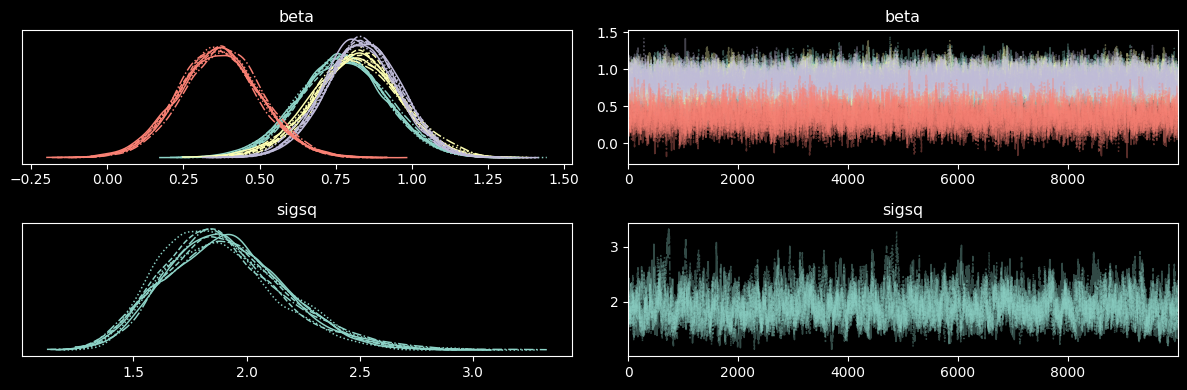

In [10]:
az.plot_trace(iddata)
plt.tight_layout()